In [1]:
import joblib
import pandas as pd
import numpy as np
from transformers import BartTokenizer

In [2]:
import sys

MOD_FOLDER = '../'
# setting path to enable import from the parent directory
sys.path.append(MOD_FOLDER)
print(sys.path)

['/scratch/zhivar/prototex_custom/Notebooks', '/scratch/zhivar/anaconda3/envs/prototex/lib/python39.zip', '/scratch/zhivar/anaconda3/envs/prototex/lib/python3.9', '/scratch/zhivar/anaconda3/envs/prototex/lib/python3.9/lib-dynload', '', '/scratch/zhivar/anaconda3/envs/prototex/lib/python3.9/site-packages', '../']


In [3]:
tokenizer = BartTokenizer.from_pretrained('ModelTC/bart-base-mnli')


train_df = pd.read_csv("../data/finegrained/train.csv")
val_df = pd.read_csv("../data/finegrained/val.csv")
test_df = pd.read_csv("../data/finegrained/test.csv")

train_sentences = train_df['text'].tolist()
test_sentences = test_df['text'].tolist()
train_labels = train_df['label'].tolist()
val_labels = val_df['label'].tolist()
test_labels = test_df['label'].tolist()

In [4]:
bestk_train_data_per_proto = joblib.load("../artifacts/bestk_train_data_per_proto.joblib")
best_protos_per_testeg = joblib.load("../artifacts/best_protos_per_testeg.joblib")

In [5]:
bestk_train_data_per_proto[0].shape

(50, 5)

In [6]:
best_protos_per_testeg[0].shape

torch.Size([331, 5])

#### Accuracy of test example label being present in the topk train sample labels close to the best prototype.

In [7]:
results = []
for test_index, test_sample_prototypes in enumerate(best_protos_per_testeg[0]):
    test_sample_label = test_labels[test_index]
    respective_prototypes_train_labels = []
    for prototype in test_sample_prototypes:
        prototype_train_labels = []
        train_samples_close_to_prototype = bestk_train_data_per_proto[0][prototype]
        for train_sample in train_samples_close_to_prototype:
            prototype_train_labels.append(train_labels[train_sample])
        respective_prototypes_train_labels.append(prototype_train_labels)
    results.append((test_sample_label, respective_prototypes_train_labels))

In [8]:
def get_accuracy_of_model_on_label(results, k = 5):
    statistics = []
    for test_label, prototypes_train_labels in results:
        per_test_statistics = []
        for prototype_train_labels in prototypes_train_labels:
            per_test_statistics.append(test_label in prototype_train_labels)
        statistics.append(per_test_statistics)
    statistics = np.array(statistics)
    return np.round(np.mean(np.sum(statistics[:,:k], axis = 1) != 0), 3)

In [9]:
from collections import defaultdict
accuracies = defaultdict(list)
for k in [5, 3, 1]:
    overall_accuracy = get_accuracy_of_model_on_label(results, k)
    accuracies[k].append(overall_accuracy)
    for label in set(train_labels):
        if label == "O": 
            continue
        label_specific_accuracy = get_accuracy_of_model_on_label([result for result in results if result[0] == label], k)
        accuracies[k].append(label_specific_accuracy)
report_labels = list(set(train_labels))
        

In [10]:
report_df = pd.DataFrame(
    {
        'class': [
            'overall',
            *report_labels
        ],
        'k = 5': accuracies[5],
        'k = 3': accuracies[3],
        'k = 1': accuracies[1]
    }
)

In [11]:
report_df

,class,k = 5,k = 3,k = 1
0,overall,0.882,0.770,0.580
1,false dilemma,0.947,0.895,0.895
2,ad hominem,1.000,1.000,0.923
3,appeal to emotion,0.826,0.783,0.609
4,circular reasoning,1.000,0.826,0.652
5,faulty generalization,0.950,0.867,0.683
6,fallacy of extension,0.944,0.500,0.000
7,fallacy of relevance,0.818,0.636,0.409
8,equivocation,0.571,0.000,0.000
9,ad populum,0.968,0.935,0.871


### Overlapping prototypes for each training label

In [12]:
best_protos_per_traineg = joblib.load("../artifacts/best_protos_per_traineg.joblib")
train_prototype_sentences = defaultdict(set)
for train_index, train_sample_prototypes in enumerate(best_protos_per_traineg[0]):
    for prototype in train_sample_prototypes.tolist()[:3]:
        train_prototype_sentences[train_labels[train_index]].add(prototype)
for key, values in train_prototype_sentences.items():
    print(f"{key}: {values}")

fallacy of logic: {0, 1, 2, 35, 36, 38, 7, 43, 46, 16, 18, 22, 25, 28, 29}
circular reasoning: {0, 2, 35, 36, 34, 39, 16, 17, 19, 20, 23, 25, 27, 28, 30}
appeal to emotion: {0, 33, 2, 34, 36, 37, 35, 38, 40, 41, 7, 8, 13, 46, 14, 45, 22, 26}
intentional: {0, 1, 2, 6, 9, 11, 12, 14, 16, 20, 22, 23, 24, 28, 30, 34, 36, 37, 39, 40, 42, 48, 49}
faulty generalization: {1, 2, 3, 7, 9, 10, 12, 13, 17, 18, 22, 25, 26, 28, 30, 32, 33, 34, 36, 37, 38, 42, 46, 47, 49}
fallacy of extension: {0, 1, 2, 5, 8, 9, 12, 13, 18, 19, 23, 24, 26, 29, 34, 36, 37, 40, 41, 44, 46, 49}
false dilemma: {32, 1, 34, 36, 37, 9, 10, 12, 13, 46, 15, 18, 20, 26, 28, 29, 30}
ad populum: {0, 2, 4, 11, 12, 17, 21, 25, 28, 33, 34, 36, 37, 39, 41, 43, 45, 48, 49}
ad hominem: {34, 2, 36, 8, 41, 42, 11, 44, 49, 18, 19}
false causality: {0, 2, 3, 4, 36, 35, 42, 12, 13, 46, 15, 20, 22, 23, 25, 28, 29, 31}
equivocation: {0, 1, 2, 3, 5, 10, 13, 18, 20, 21, 24, 25, 30, 31, 34, 35, 38, 39, 46, 47, 48}
fallacy of relevance: {0, 1, 2

In [13]:
best_protos_per_testeg = joblib.load("../artifacts/best_protos_per_testeg.joblib")
test_prototype_sentences = defaultdict(set)
for test_index, test_sample_prototypes in enumerate(best_protos_per_testeg[0]):
    for prototype in test_sample_prototypes.tolist()[:3]:
        test_prototype_sentences[test_labels[test_index]].add(prototype)
for key, values in test_prototype_sentences.items():
    print(f"{key}: {values}")

false dilemma: {0, 1, 34, 2, 36, 39, 9, 12, 13, 46, 49, 18, 25, 26, 28}
faulty generalization: {0, 1, 2, 4, 7, 8, 9, 12, 13, 18, 22, 23, 25, 26, 28, 29, 30, 33, 34, 36, 38, 40, 42, 43, 46, 47, 49}
fallacy of credibility: {0, 1, 34, 2, 36, 5, 38, 8, 43, 46, 49, 18, 19, 20, 24, 26, 28}
fallacy of relevance: {0, 1, 34, 2, 36, 41, 44, 13, 46, 16, 49, 18, 20, 22, 23, 24, 25, 28}
fallacy of logic: {0, 1, 2, 34, 36, 43, 13, 46, 18, 25, 26, 28, 29}
ad hominem: {0, 1, 2, 7, 8, 12, 18, 19, 22, 24, 25, 31, 34, 36, 37, 39, 40, 41, 46, 49}
circular reasoning: {0, 1, 34, 2, 36, 39, 46, 25, 27, 28, 29, 30}
ad populum: {0, 1, 2, 34, 4, 37, 36, 39, 38, 41, 6, 43, 46, 48, 21, 25, 28}
false causality: {0, 1, 2, 3, 12, 16, 18, 20, 22, 24, 25, 26, 28, 34, 36, 39, 40, 42, 46}
fallacy of extension: {0, 1, 2, 34, 36, 39, 8, 46, 18, 19, 24, 25, 26, 29}
intentional: {0, 1, 34, 2, 36, 6, 39, 41, 12, 46, 14, 49, 18, 22, 26, 28}
appeal to emotion: {0, 1, 2, 34, 36, 43, 13, 46, 22, 25, 26, 28}
equivocation: {0, 1, 

### Clustering prototype tensors

In [14]:
import seaborn as sns
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

In [15]:
import torch
all_protos = torch.load("../artifacts/all_protos.pt")
all_protos = all_protos.cpu()
print(all_protos.shape)
num_protos = 50
all_protos = all_protos.view(num_protos, -1)
print(all_protos.shape)
print(all_protos.min())
print(all_protos.max())

torch.Size([50, 128, 768])
torch.Size([50, 98304])
tensor(-0.0335, grad_fn=<MinBackward1>)
tensor(0.0288, grad_fn=<MaxBackward1>)


(50, 2)


<Axes: xlabel='2nd component', ylabel='1st component'>

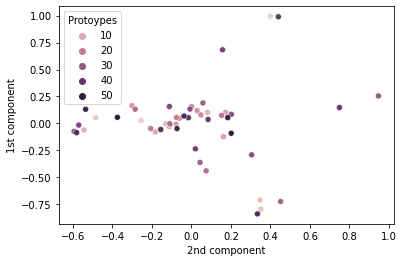

In [16]:
pca = PCA(n_components=2)
all_protos_transformed = pca.fit_transform(all_protos.detach().numpy())
print(all_protos_transformed.shape)

proto_df = {
    "1st component": all_protos_transformed[:,0].tolist(),
    "2nd component": all_protos_transformed[:,1].tolist(),
    "Protoypes": np.arange(1, 51).tolist()
}
sns.scatterplot(data=proto_df, x="2nd component", y="1st component", hue="Protoypes")

(50, 2)


<Axes: xlabel='Y', ylabel='X'>

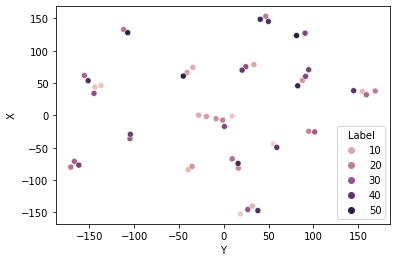

In [17]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=2)
all_protos_transformed = tsne.fit_transform(all_protos.detach().numpy())
print(all_protos_transformed.shape)

proto_df = {
    "X": all_protos_transformed[:,0].tolist(),
    "Y": all_protos_transformed[:,1].tolist(),
    "Label": np.arange(1, 51).tolist()
}
sns.scatterplot(data=proto_df, x="Y", y="X", hue="Label")

(50, 2)


<Axes: xlabel='Y', ylabel='X'>

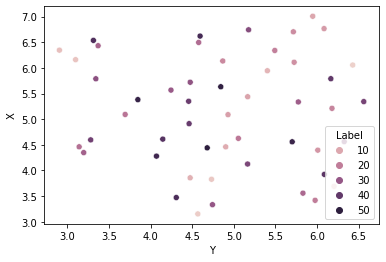

In [18]:
import umap
reducer = umap.UMAP()
all_protos_transformed = reducer.fit_transform(all_protos.detach().numpy())
print(all_protos_transformed.shape)

proto_df = {
    "X": all_protos_transformed[:,0].tolist(),
    "Y": all_protos_transformed[:,1].tolist(),
    "Label": np.arange(1, 51).tolist()
}
sns.scatterplot(data=proto_df, x="Y", y="X", hue="Label")